# Active Learning Classifier

Notebook going over the main ideas and functions of the Active Learning classifier algorithm.

The main idea is to apply the _AL_ concepts to a supevised classification problem.
We will use as an example a very simple dataframe that contains only 2-features and 3-classes (_e.g._, resembling a 3-phases 2D phase diagram) 

In [1]:
import numpy as np
import pandas as pd

import activeclf as alclf

## Input data

In [2]:
data_dir = '../example/dummy_dataset/2d_ani_space/'
data_file = 'aniSpace2D_ward_phases3.csv'

In [3]:
# load the data from the file path

data = alclf.DataLoader(file_path=data_dir+data_file)

Loading DataFrame ...



In [4]:
# the dataframe can be accessed directly

data.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       500 non-null    float64
 1   y       500 non-null    float64
 2   target  500 non-null    float64
dtypes: float64(3)
memory usage: 11.8 KB


In [5]:
# separation of the target variable and the feature space variables

data.feature_space(target='target')

Feature space: ['x', 'y'],
Target property: target
Scaling the data (StandarScaler) ...


In [6]:
data.X.head()

x         y
0  0.645086  1.617050
1 -1.598243 -1.679313
2  1.713614 -1.739310
3 -1.644755  0.980752
4  0.096112 -0.412903

In [7]:
data.y.head()

0    0.0
1    2.0
2    1.0
3    0.0
4    1.0
Name: target, dtype: float64

In [8]:
data.fspace_keys

['x', 'y']

### Plots

In [9]:
import matplotlib.pyplot as plt
from activeclf.utils.beauty import get_axes

In [10]:
# definition of the specific separate variables
# for simplicity

X0 = data.X[data.fspace_keys[0]]
X1 = data.X[data.fspace_keys[1]]

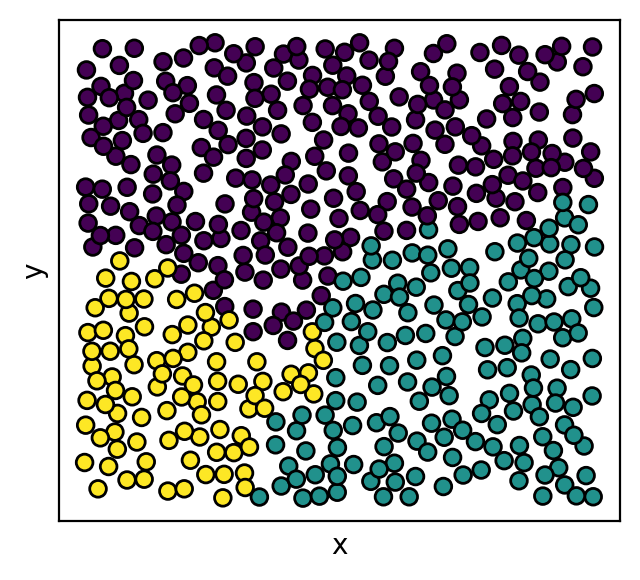

In [11]:
fig, ax = get_axes(1,1)
ax.scatter(X0,X1,
           c=data.y,
           edgecolor='0.')

ax.set_xlabel(data.fspace_keys[0])
ax.set_ylabel(data.fspace_keys[1])
ax.set_xticks(())
ax.set_yticks(())

fig.tight_layout()

## AL classifier experiment

The Active Learning Classifier is built by 2 general fundamental steps:

1. **Classification**: the model chosen to classify the initial starting data points (_e.g._, GP classifier, SV classifier, etc.);
2. **Acquisition**: the mode in which new points are selected (_e.g._, expoitation, exploration, random)

Following these two steps the AL-classifier takes in input the initial batch of points and outputs, for every cycle, a new batch of points that are regarded as "interesting".

### Classification

Selects which classification algorithm to use throughout the AL experiment.

The classifier are just selected from a list of classifier available in sklern and they can be set up with a bunch of args and kwargs following the original implementation.

In this example we will use `GaussianProcessClassifier`.

In [12]:
from sklearn.metrics import accuracy_score

In [13]:
clf_model = 'GaussianProcessClassifier'

clf_dict = dict(
    kernel=1.0 * alclf.classification.RBF(1.0), 
    random_state=73
)

In [14]:
oneshot_clf = alclf.ClassifierModel(model=clf_model, **clf_dict)

In [15]:
# the original classifier class can be acessed

oneshot_clf.clf

GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1), random_state=73)

We can appreciate how the chosen clf work by doing a "one-shot" classification experiment on the data.

In [16]:
# `idxs=None` makes the class select all the available points

oneshot_clf.fit(data.X, data.y, idxs=None)

/home/andreag/anaconda3/envs/coacerv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GaussianProcessClassifier was fitted with feature names
  warnings.warn(


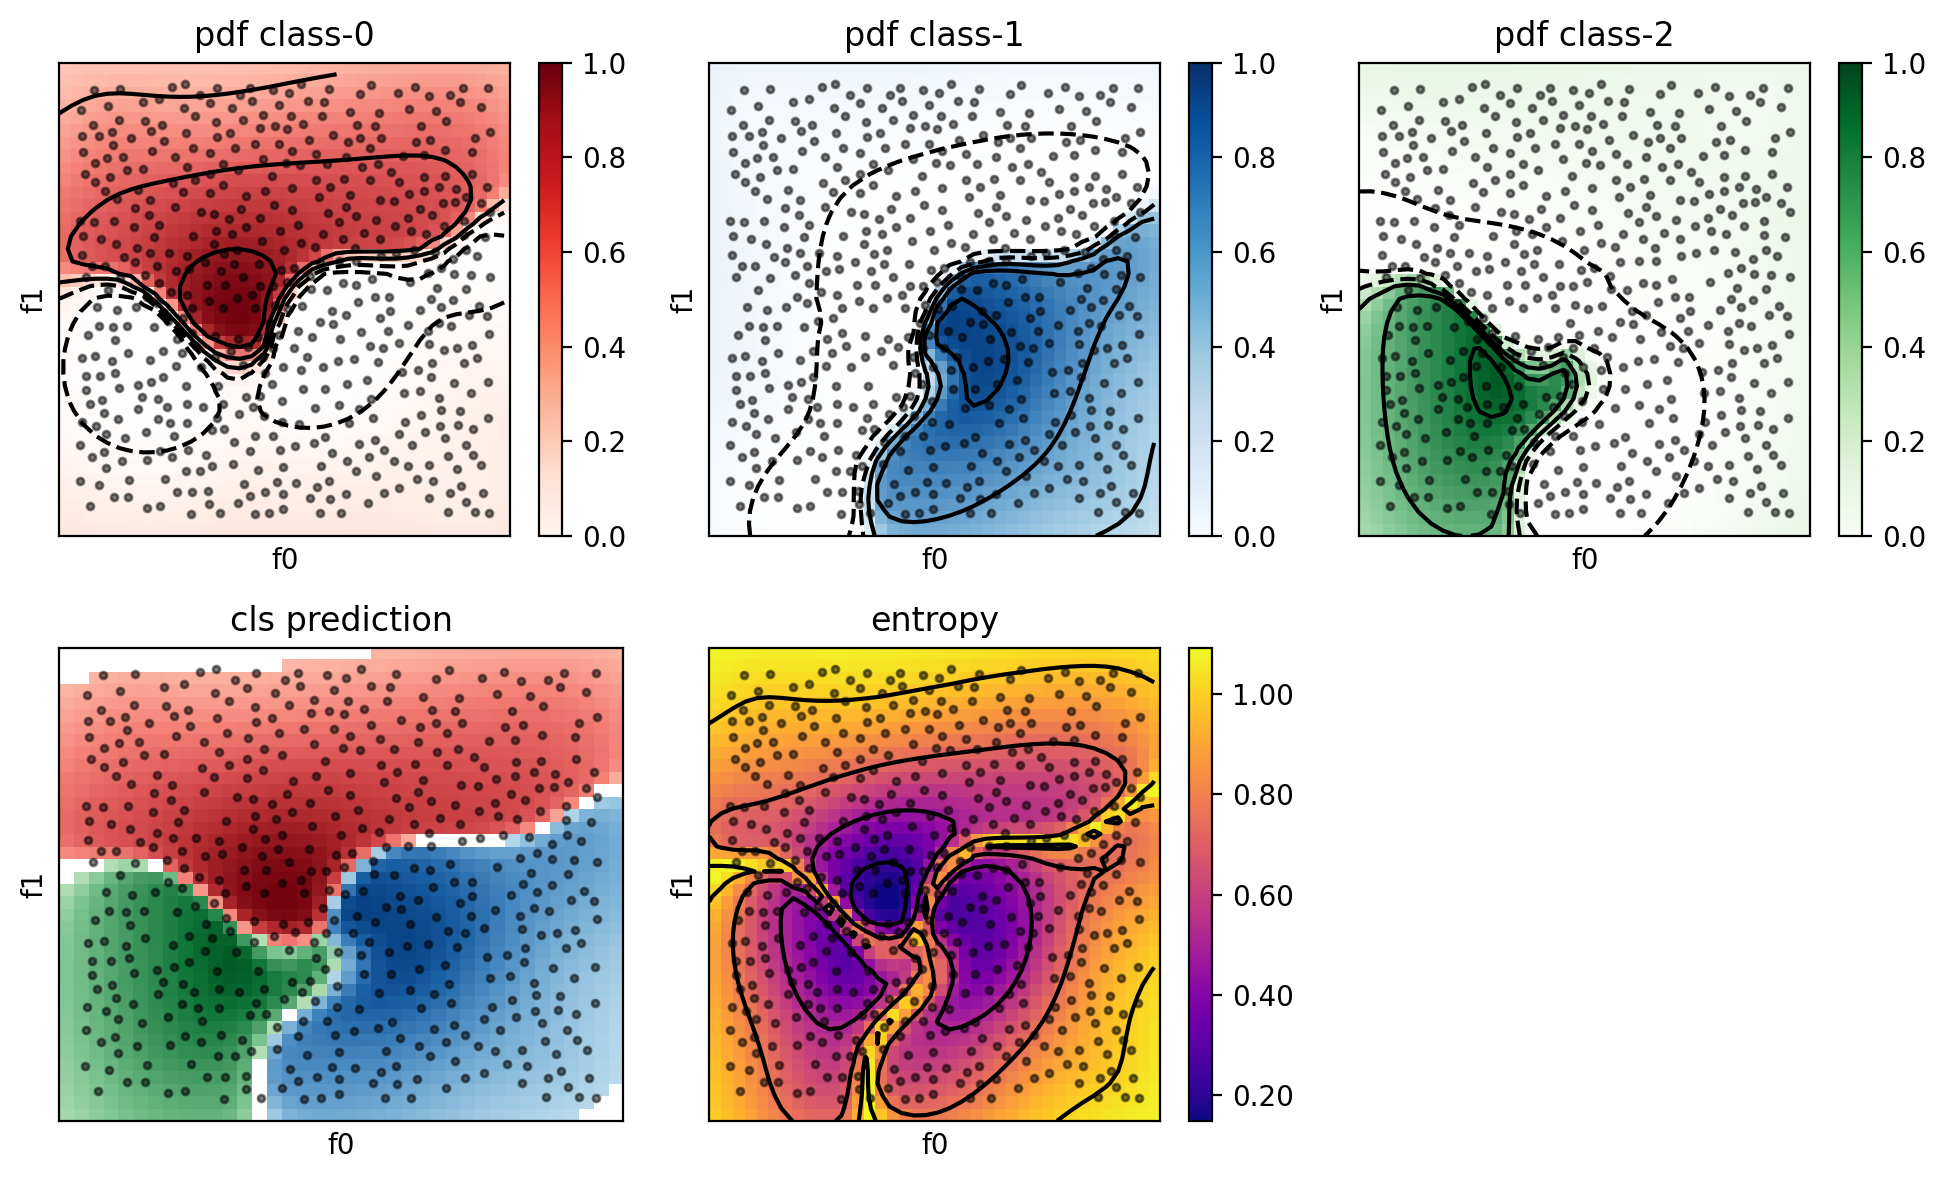

In [17]:
alclf.beauty.plot_classification2D(data=data.X, 
                                   feature_variable=data.fspace_keys, 
                                   clfModel=oneshot_clf)

We can compute the accuracy of the one shot evaluation of the clf algorithm using all the possible points available.

Of course using less points would decrease the accuracy of the model.
For example if we pick random points from the ones available and try to fit the clf we will obtain different values for the accuracy.

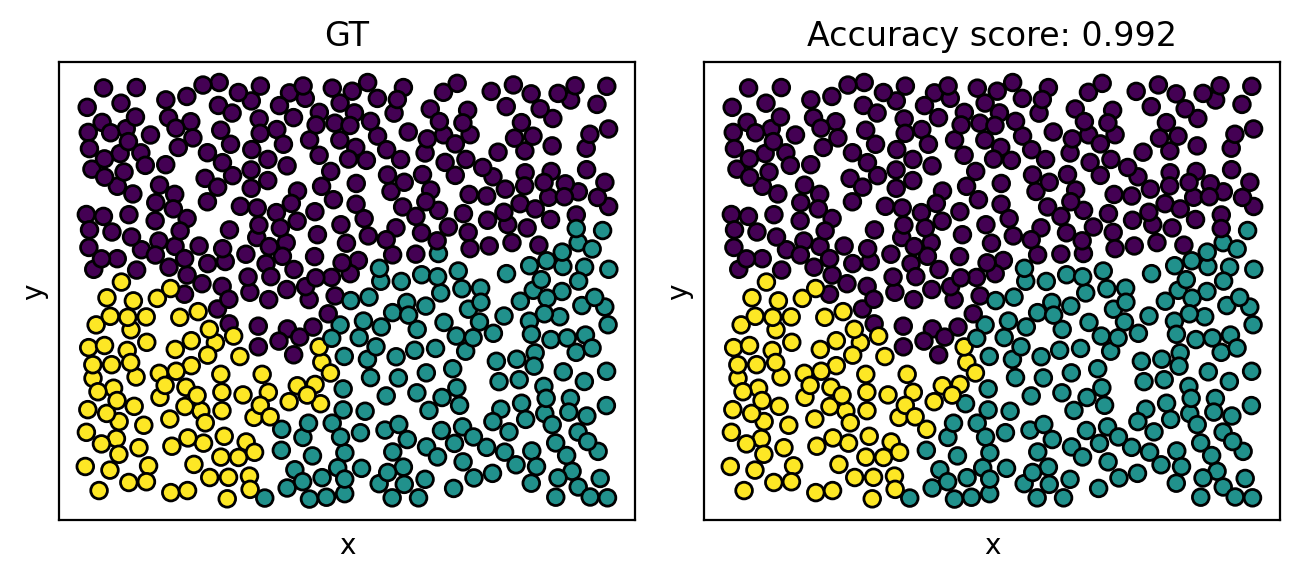

In [18]:
fig, ax = get_axes(2,2)
ax[0].scatter(X0,X1, c=data.y, edgecolor='0.')
ax[0].set_title('GT')

y_pred = oneshot_clf.clf.predict(data.X)
ax[1].scatter(X0,X1, c=y_pred, edgecolor='0.')
ax[1].set_title(f'Accuracy score: {accuracy_score(y_pred=y_pred, y_true=data.y)}')

for i in range(2):
    ax[i].set_xlabel(data.fspace_keys[0])
    ax[i].set_ylabel(data.fspace_keys[1])
    ax[i].set_xticks(())
    ax[i].set_yticks(())

fig.tight_layout()

## Acquisition

The acquisition steps serve the purpouse of acquiring new interesting points following some acquisition rules.
These rules will be based on the concept of information Entropy computed from the probability distribution function that is fitted from the application of the classifier.

Each classifier returns a different probability space, that can be smooth or not depending on the functions that fit the datapoints into classes.
The principal ingredient is the estimation of probability of belonging to a specific class, that will be later used to compute the Entropy of the underlaying pool of points.

We will start our experiment by considering only 4 points taken from `data.X` and we will fit a first instance of the classification algorithm.

In [19]:
# 'random' indexes

rng_idx_tmp = [322, 186, 289, 360]

In [20]:
al_clf = alclf.ClassifierModel(model=clf_model, **clf_dict)
al_clf.fit(X=data.X, y=data.y, idxs=rng_idx_tmp)

/home/andreag/anaconda3/envs/coacerv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GaussianProcessClassifier was fitted with feature names
  warnings.warn(


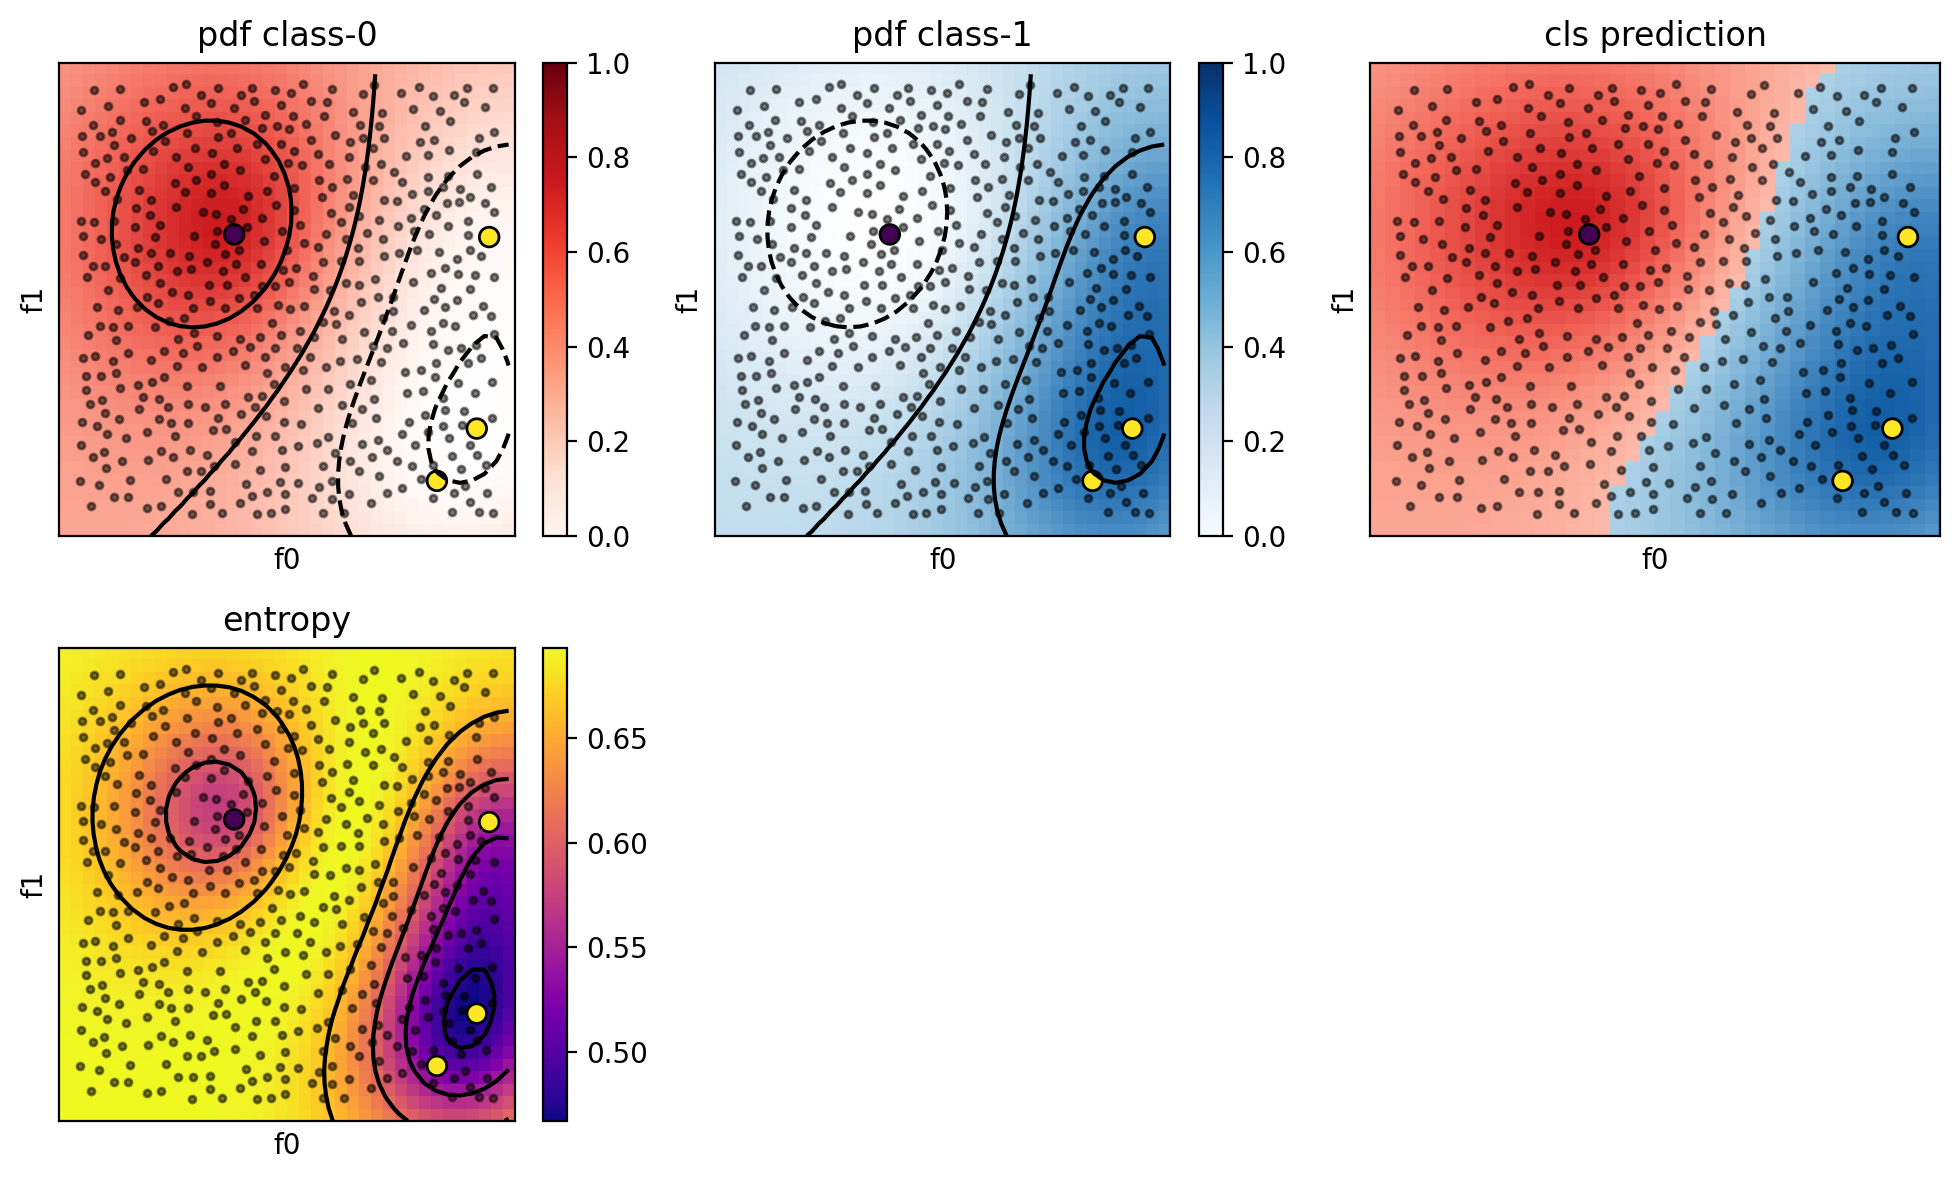

In [21]:
alclf.beauty.plot_classification2D(data=data.X, 
                                   feature_variable=data.fspace_keys, 
                                   clfModel=al_clf, 
                                   points_ndx=rng_idx_tmp)

We can access the probability distribution function of the multiclass problem by using the `predict_probability` method; this is just a wrapper calling the actual sklearn implementation of the classifier.

In [22]:
Z = al_clf.predict_proba(X=data.X)

Each line of `Z` contain the probability of belonging to each classes, summing to 1.

In [23]:
Z[:5]

array([[0.51164198, 0.48835802],
       [0.5118953 , 0.4881047 ],
       [0.24831815, 0.75168185],
       [0.60816559, 0.39183441],
       [0.51684989, 0.48315011]])

We will exploit the concept of (Shannon) Entropy 

$H = -\sum(p_k \log(p_k))$

to weight the choice of new points for our future cycles.

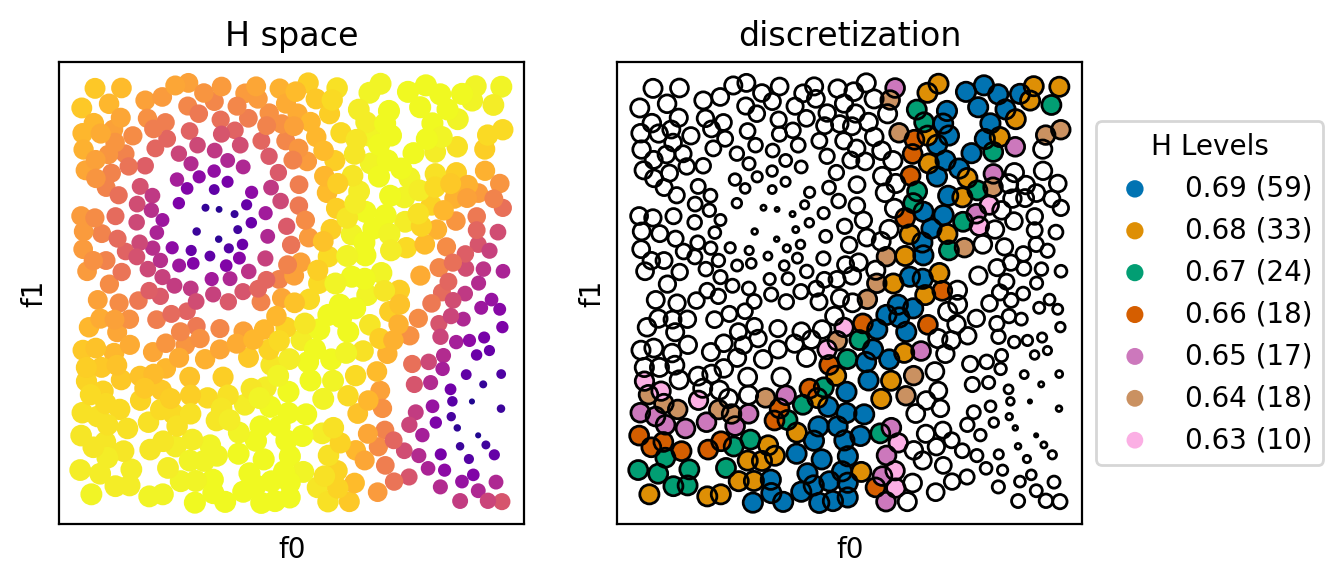

In [24]:
alclf.beauty.plot_entropy(X=(X0,X1), Z=Z, levels=7, decimals=2)

Depending on the numerical discretization we obtain a finer representation and resolution on the Entropy-space.

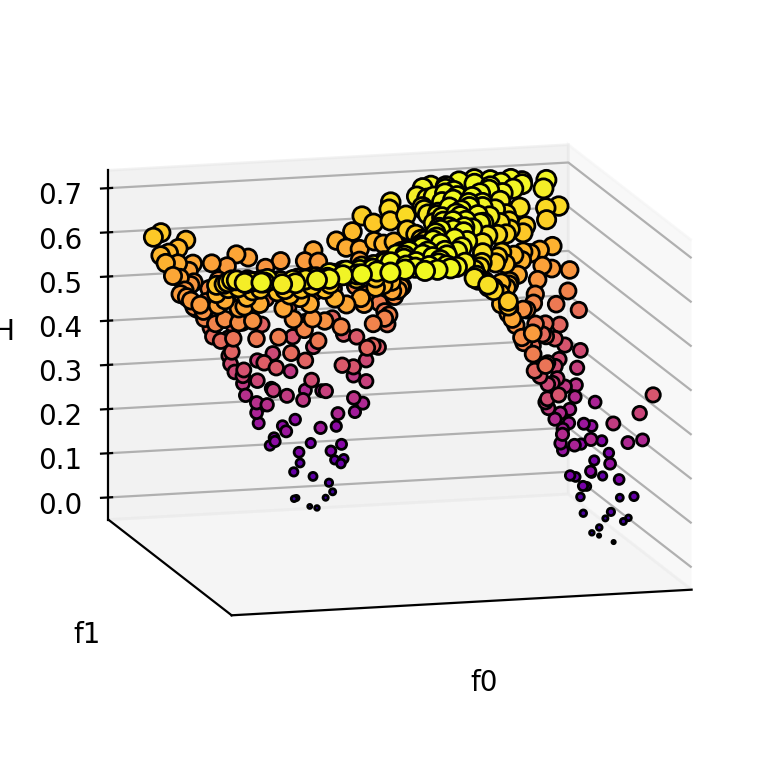

In [25]:
alclf.beauty.plot_entropy3D(X=(X0,X1), Z=Z, decimals=2, orientation=(-105,12))

In [26]:
import scipy
from sklearn.preprocessing import MinMaxScaler

In [27]:
Z = MinMaxScaler().fit_transform(X=Z)
H = np.around(scipy.stats.entropy(pk=Z, axis=1), decimals=2)

In [28]:
new_selection = [3,6,12]

New points can be selected in three main ways:

1. **Random acquisition**: just selects N points randomly from the one available.

In [29]:
pool_idx = [i for i in list(data.X.index) if i not in rng_idx_tmp]

acqui_rng = [alclf.DecisionFunction(mode='random', seed=None).acquire(idxs=pool_idx, n=n) for n in new_selection]

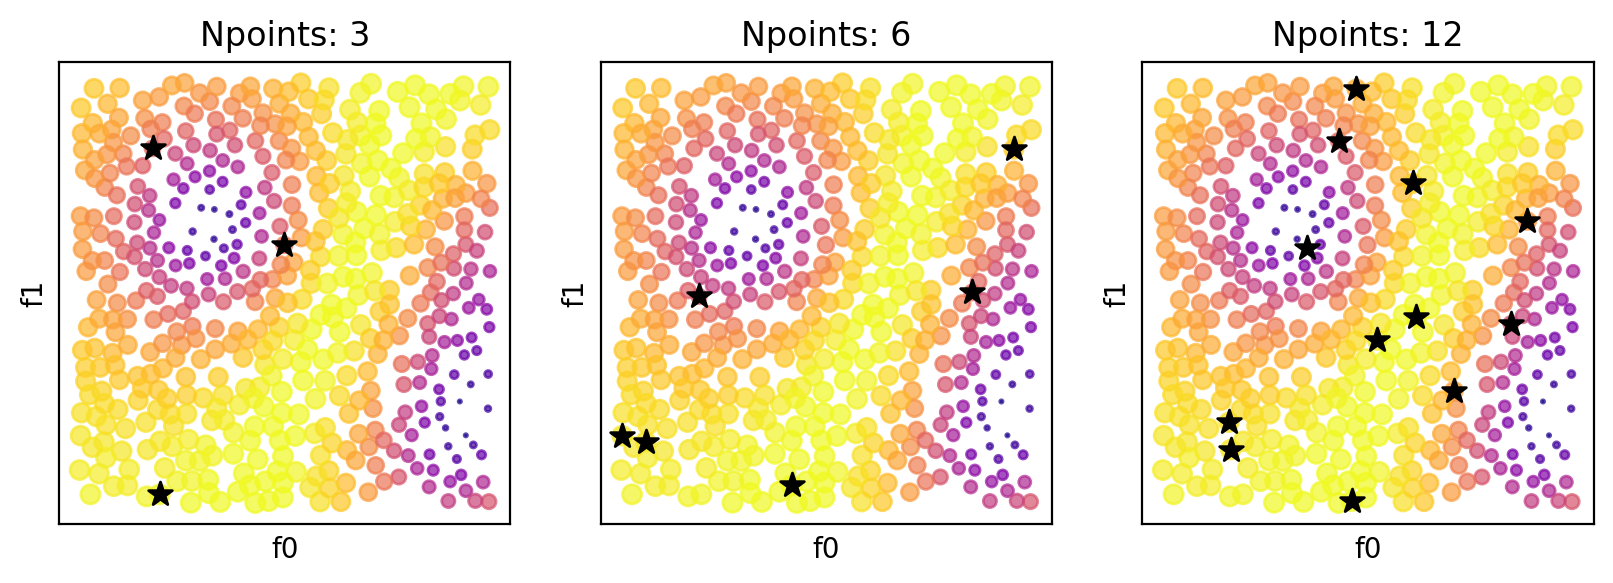

In [30]:
fig, ax = get_axes(len(acqui_rng), 3)

for i,ap in enumerate(acqui_rng):

    ax[i].scatter(X0,X1, c=H, cmap='plasma', s=H*70, marker='o', alpha=.7, zorder=1)
    ax[i].scatter(X0.iloc[ap],X1.iloc[ap], c='0.', s=80, marker='*', zorder=2)
    ax[i].set_xlabel('f0')
    ax[i].set_ylabel('f1')
    ax[i].set_title(f'Npoints: {len(ap)}')
    ax[i].set_xticks(())
    ax[i].set_yticks(())

2. **Exploration**: based on the concept of _highest_ entropy, it selects N points that have the highest entropy values, _aka_ samples the most unkown areas of the currently trained model.

In [31]:
acqui_exploration = [alclf.DecisionFunction(mode='exploration', seed=None).acquire(pdf=Z, n=n) 
                     for n in new_selection]

In this case, depending on the discretization of the Entropy space we can have a set of defenerate points that have the same Entropy values.
The solution is to sample between these points to choose only a subset of them.

The sampling of the subset of points is done in a FurthestPointSampling (FPS) fashion, but it can be random or even just "only-the-first-N-occurences".

In [32]:
sampler = alclf.acquisition.pointSampler(mode='FPS')

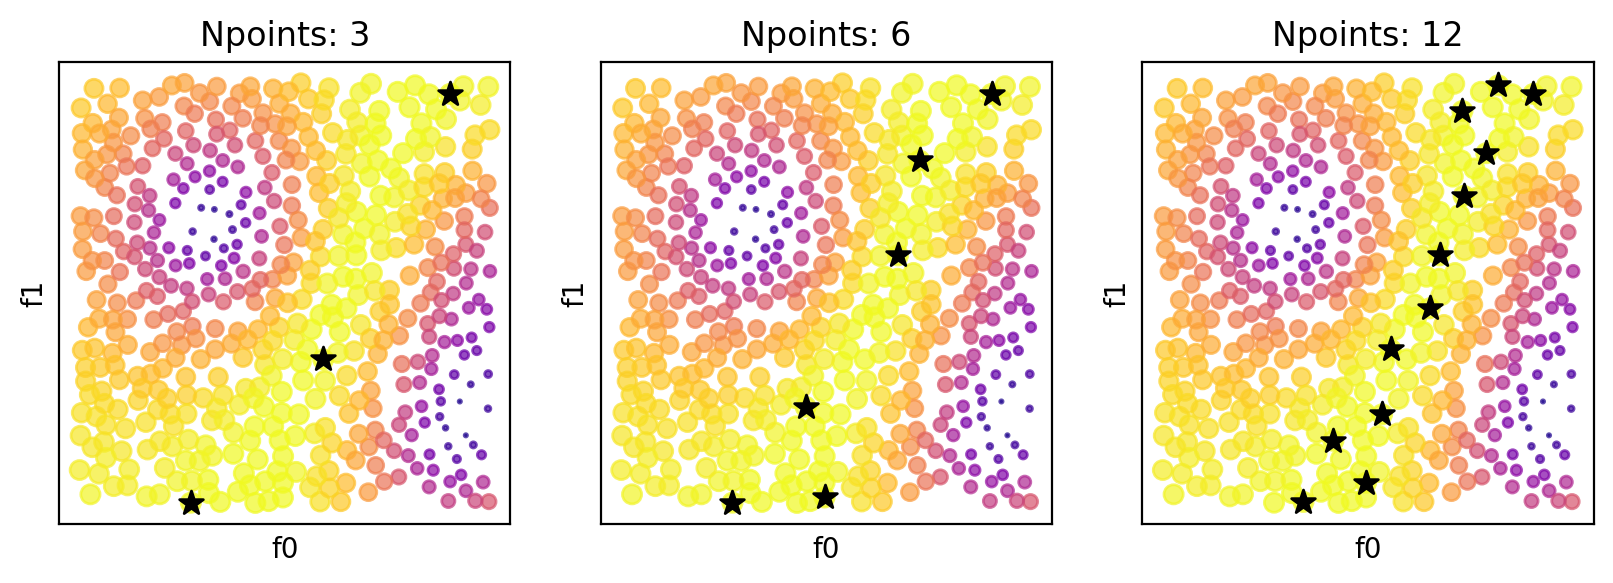

In [33]:
fig, ax = get_axes(len(acqui_rng), 3)

for i,ap in enumerate(acqui_exploration):

    if len(ap) > new_selection[i]:
        sampled_points = sampler.sample(X=data.X.iloc[ap],
                                        n=new_selection[i])
        ap_sampled = [ap[p] for p in sampled_points]
    else:
        ap_sampled = ap

    ax[i].scatter(X0,X1, c=H, cmap='plasma', s=H*70, marker='o', alpha=.7, zorder=1)
    ax[i].scatter(X0.iloc[ap_sampled],
                  X1.iloc[ap_sampled], c='0.', s=80, marker='*', zorder=2)
    ax[i].set_xlabel('f0')
    ax[i].set_ylabel('f1')
    ax[i].set_title(f'Npoints: {len(ap_sampled)}')
    ax[i].set_xticks(())
    ax[i].set_yticks(())

3. **Exploitation**: based on the opposite concept (of _exploration_), it selects N points that have the lowest entropy values, _aka_ samples the least unkown areas of the currently trained model.

In [34]:
acqui_exploitation = [alclf.DecisionFunction(mode='exploitation', seed=None).acquire(pdf=Z, n=n) 
                      for n in new_selection]

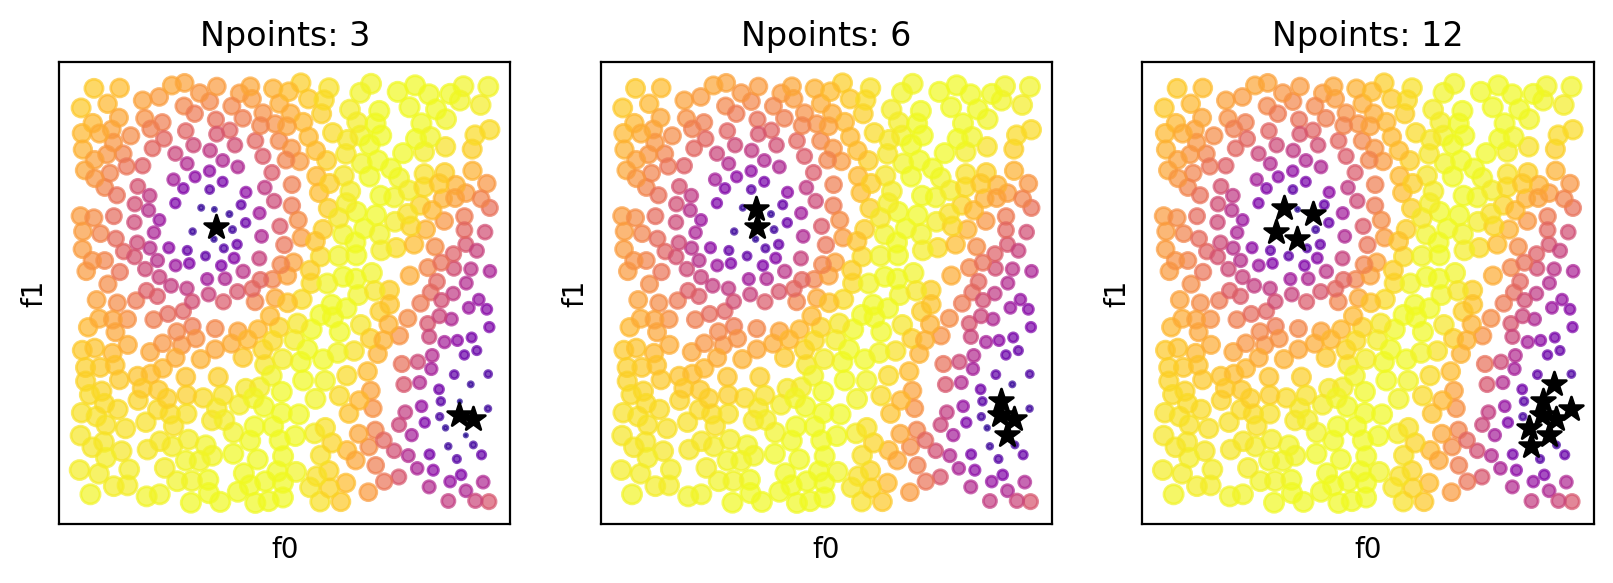

In [35]:
fig, ax = get_axes(len(acqui_rng), 3)

for i,ap in enumerate(acqui_exploitation):

    if len(ap) > new_selection[i]:
        sampled_points = sampler.sample(X=data.X.iloc[ap],
                                        n=new_selection[i])
        ap_sampled = [ap[p] for p in sampled_points]
    else:
        ap_sampled = ap

    ax[i].scatter(X0,X1, c=H, cmap='plasma', s=H*70, marker='o', alpha=.7, zorder=1)
    ax[i].scatter(X0.iloc[ap_sampled],
                  X1.iloc[ap_sampled], c='0.', s=80, marker='*', zorder=2)
    ax[i].set_xlabel('f0')
    ax[i].set_ylabel('f1')
    ax[i].set_title(f'Npoints: {len(ap_sampled)}')
    ax[i].set_xticks(())
    ax[i].set_yticks(())

## "Active Learning" cycle

Starting from the 4 points we will perform a few cycles acquiring new "interesting" points on each cycle in order to explore the feature-space landscape.

We start by setting the parameters for the experiment:

-   Classifier

In [36]:
# name as defined in the class
clf_model = 'GaussianProcessClassifier'

# specific parameters
clf_dict = dict(
    kernel=1.0 * alclf.classification.RBF(1.0), 
    random_state=73
)

clf_dict = dict(
)

al_clf = alclf.ClassifierModel(model=clf_model, **clf_dict)

-   Acquisition and sampling functions

In [37]:
ac_dict = dict(
    mode = 'exploration',
    decimals = 1,
)
ac_func = alclf.DecisionFunction(**ac_dict)

In [38]:
ac_func.mode

'exploration'

In [39]:
sampl_mode = 'FPS'

-   Starting indexes and new batch per cycle and number of cycles

In [40]:
start_idxs = [322, 186, 289, 360]
n_batch = 3
n_cycles = 7

### Cycle

In [41]:
from learning import active_learning_cycle

Cycle-0
ALpoints: 4 / 500
Found 106 points that shares the same acquisition criteria.
Selecting 3 by 'FPS' sampling.
classes: 2
Cycle-1
ALpoints: 7 / 500
Found 116 points that shares the same acquisition criteria.
Selecting 3 by 'FPS' sampling.
classes: 2


/home/andreag/anaconda3/envs/coacerv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GaussianProcessClassifier was fitted with feature names
  warnings.warn(
/home/andreag/anaconda3/envs/coacerv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GaussianProcessClassifier was fitted with feature names
  warnings.warn(


Cycle-2
ALpoints: 10 / 500
Found 18 points that shares the same acquisition criteria.
Selecting 3 by 'FPS' sampling.
classes: 3
Cycle-3
ALpoints: 13 / 500
Found 17 points that shares the same acquisition criteria.
Selecting 3 by 'FPS' sampling.
classes: 3
Cycle-4
ALpoints: 16 / 500
Found 11 points that shares the same acquisition criteria.
Selecting 3 by 'FPS' sampling.
classes: 3


/home/andreag/anaconda3/envs/coacerv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GaussianProcessClassifier was fitted with feature names
  warnings.warn(
/home/andreag/anaconda3/envs/coacerv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GaussianProcessClassifier was fitted with feature names
  warnings.warn(
/home/andreag/anaconda3/envs/coacerv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GaussianProcessClassifier was fitted with feature names
  warnings.warn(


Cycle-5
ALpoints: 19 / 500
Found 8 points that shares the same acquisition criteria.
Selecting 3 by 'FPS' sampling.
classes: 3
Cycle-6
ALpoints: 22 / 500
Found 6 points that shares the same acquisition criteria.
Selecting 3 by 'FPS' sampling.
classes: 3


/home/andreag/anaconda3/envs/coacerv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GaussianProcessClassifier was fitted with feature names
  warnings.warn(
/home/andreag/anaconda3/envs/coacerv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GaussianProcessClassifier was fitted with feature names
  warnings.warn(


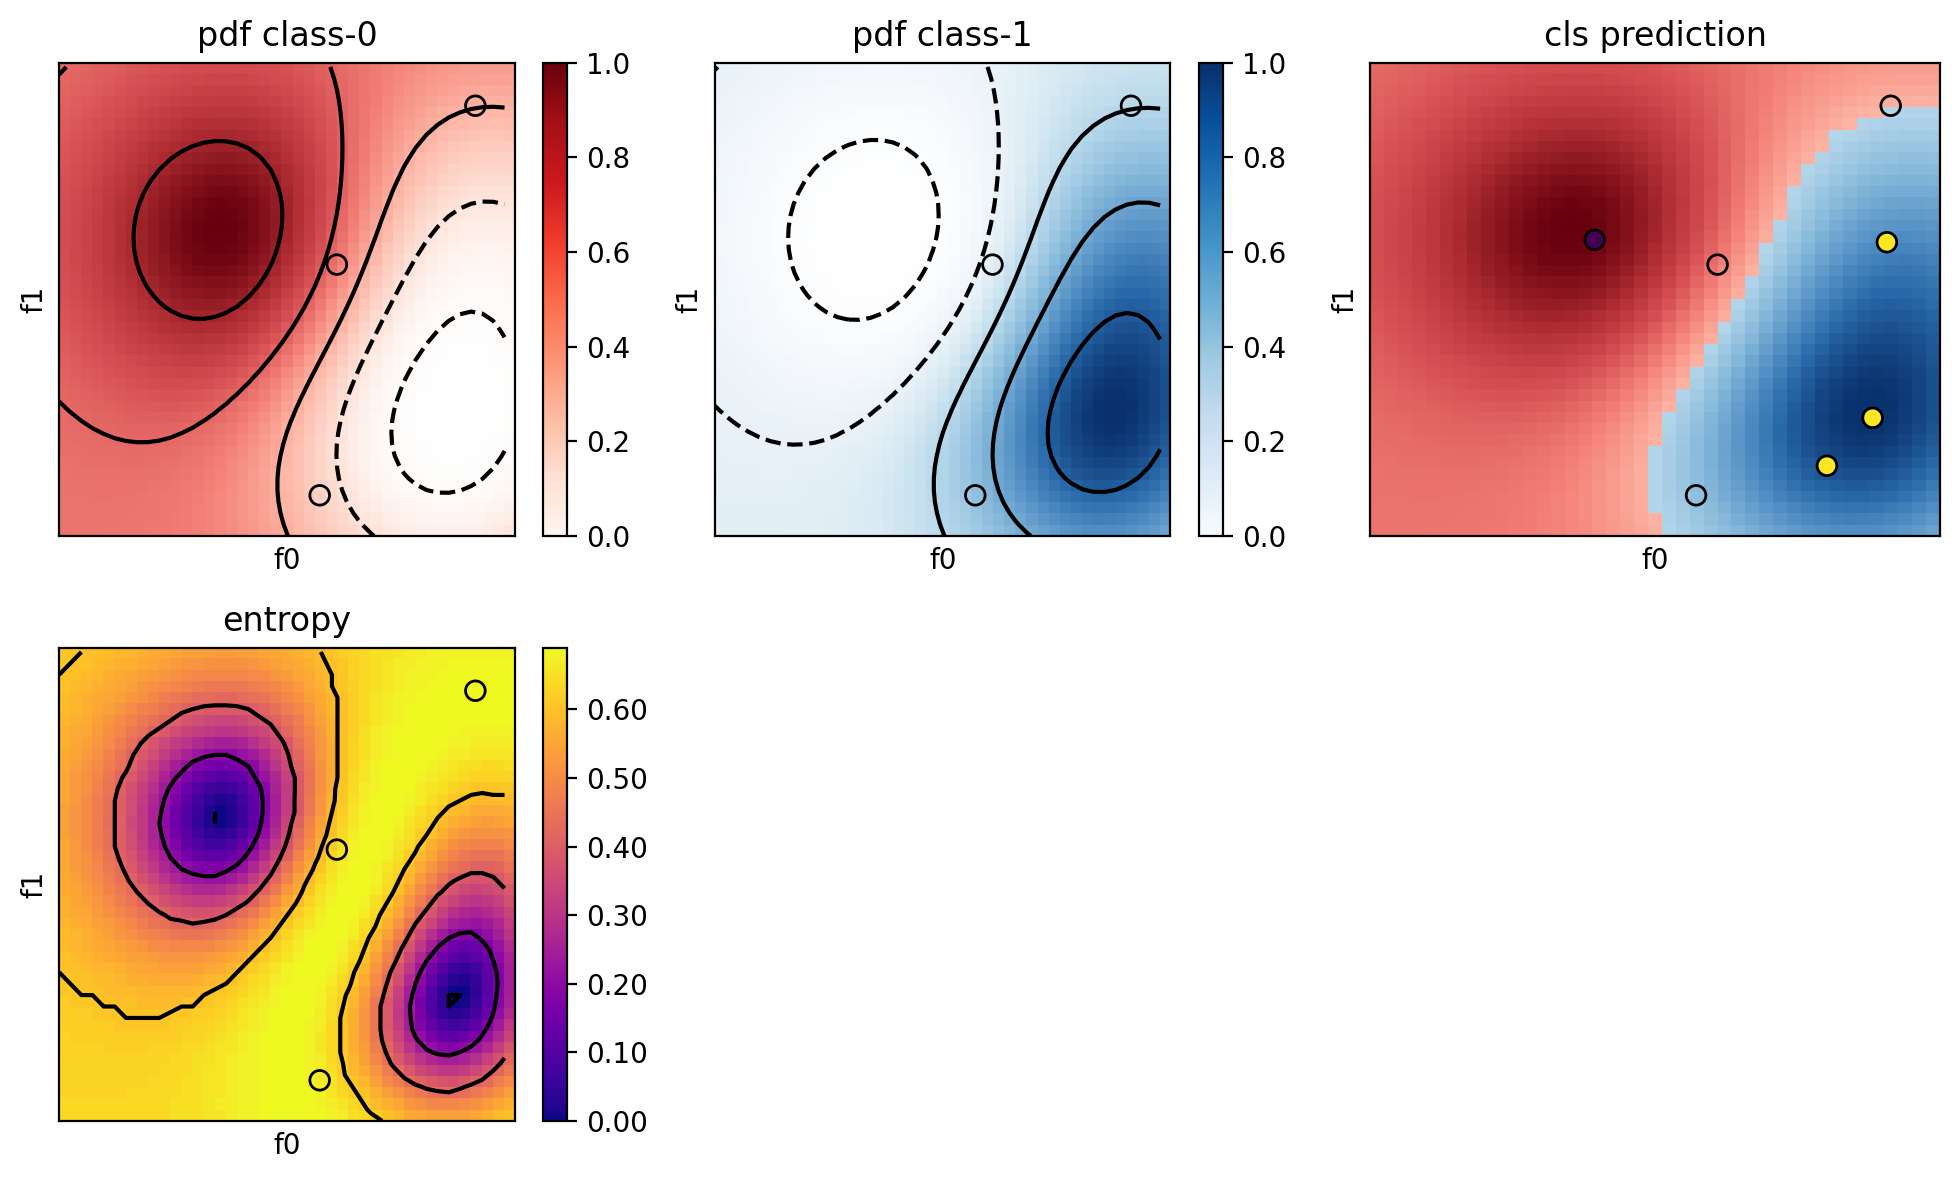

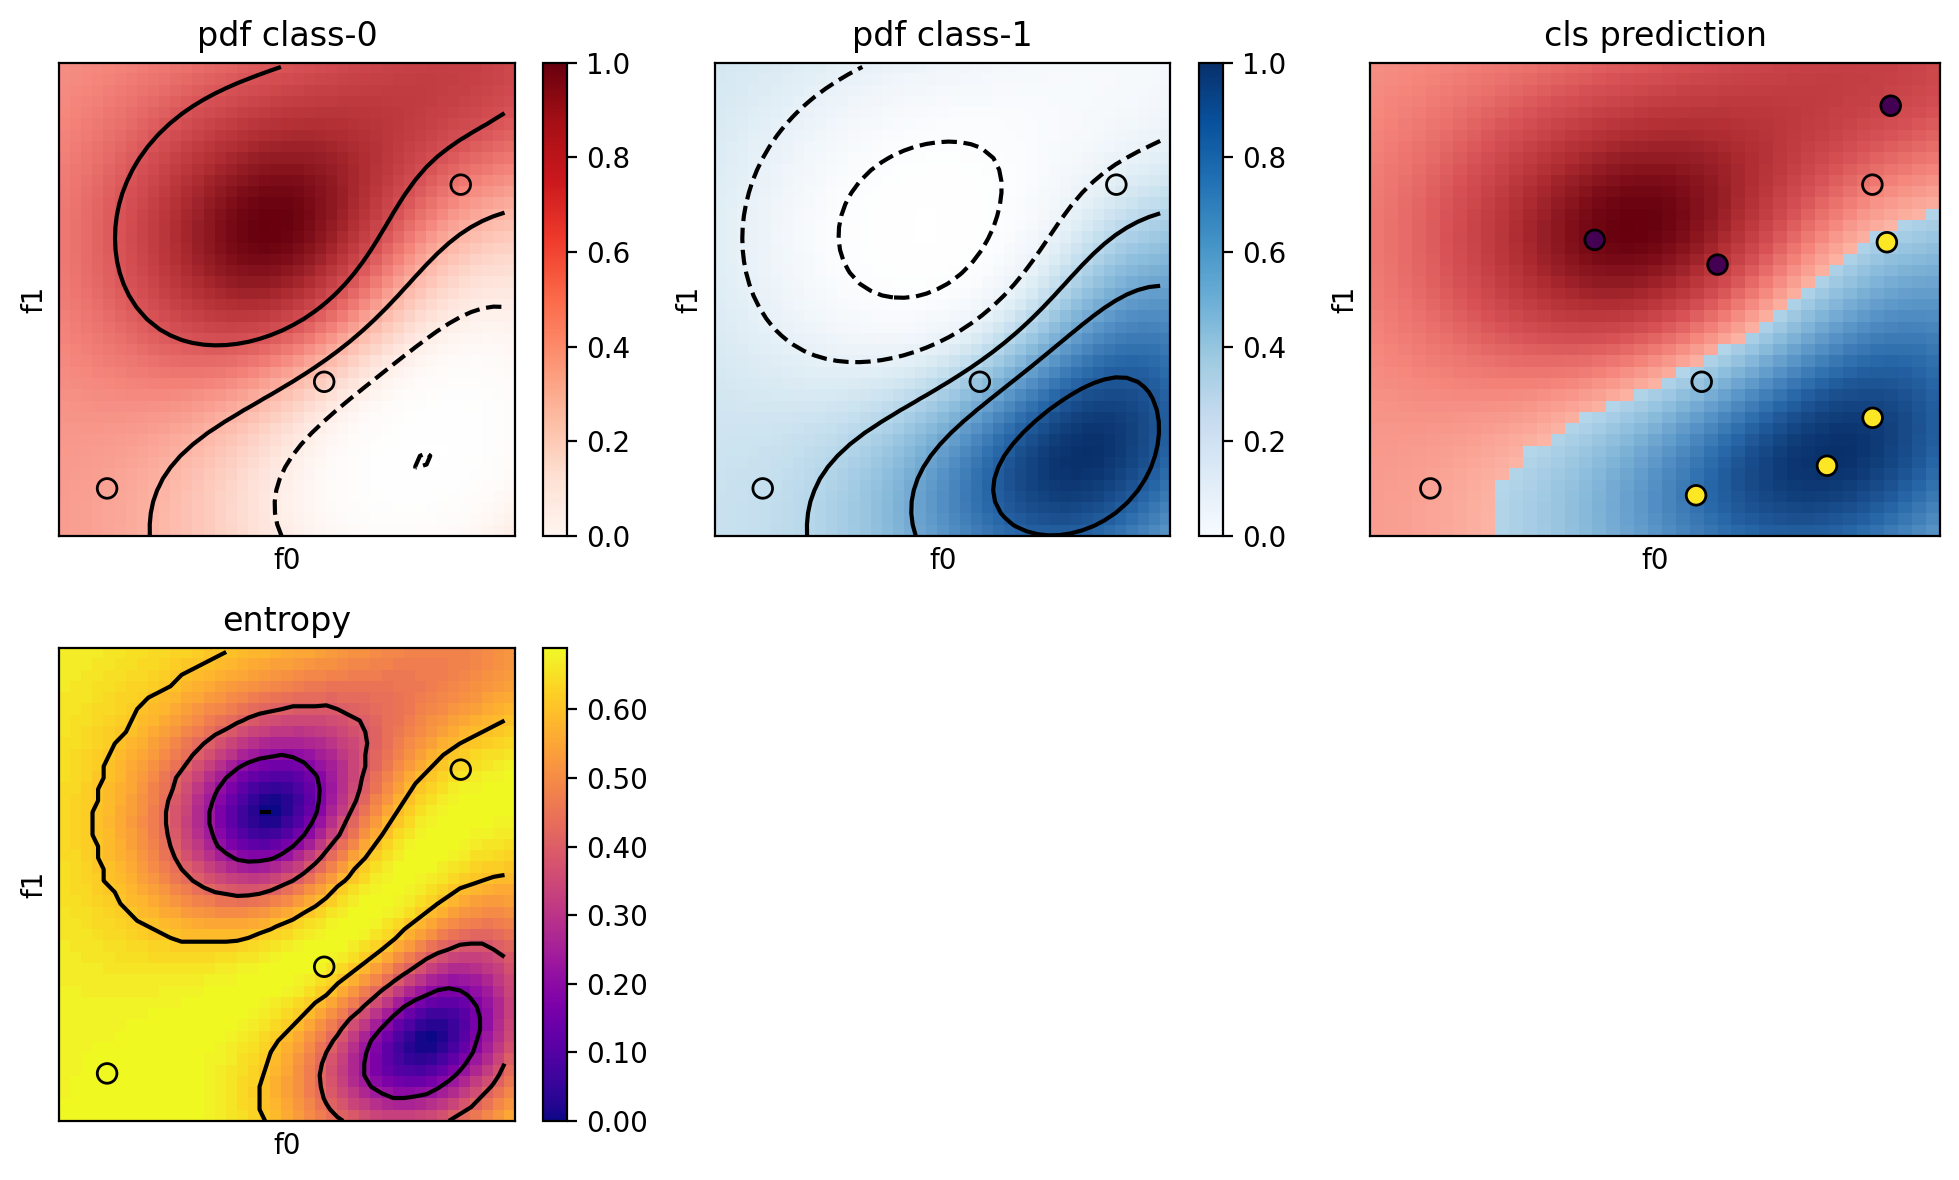

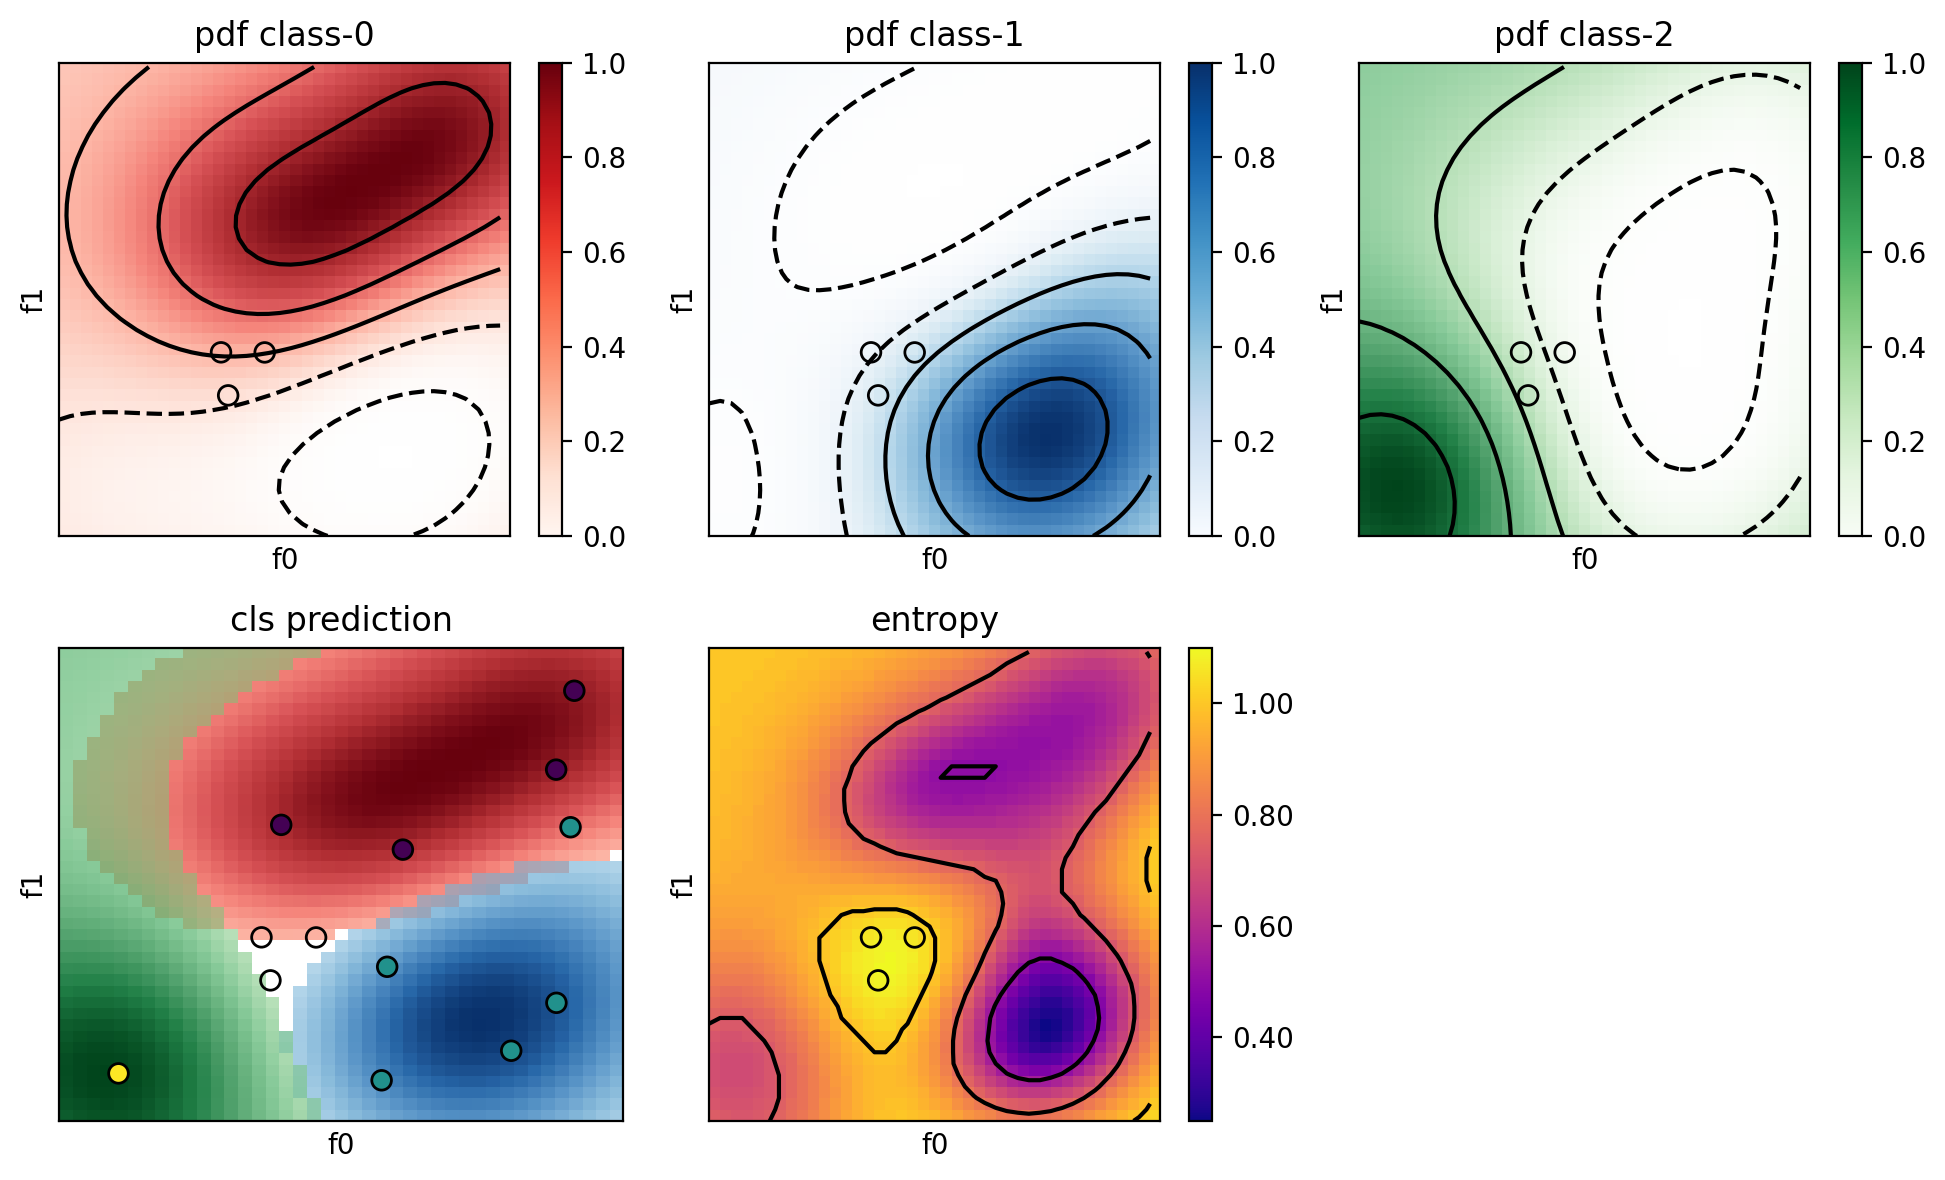

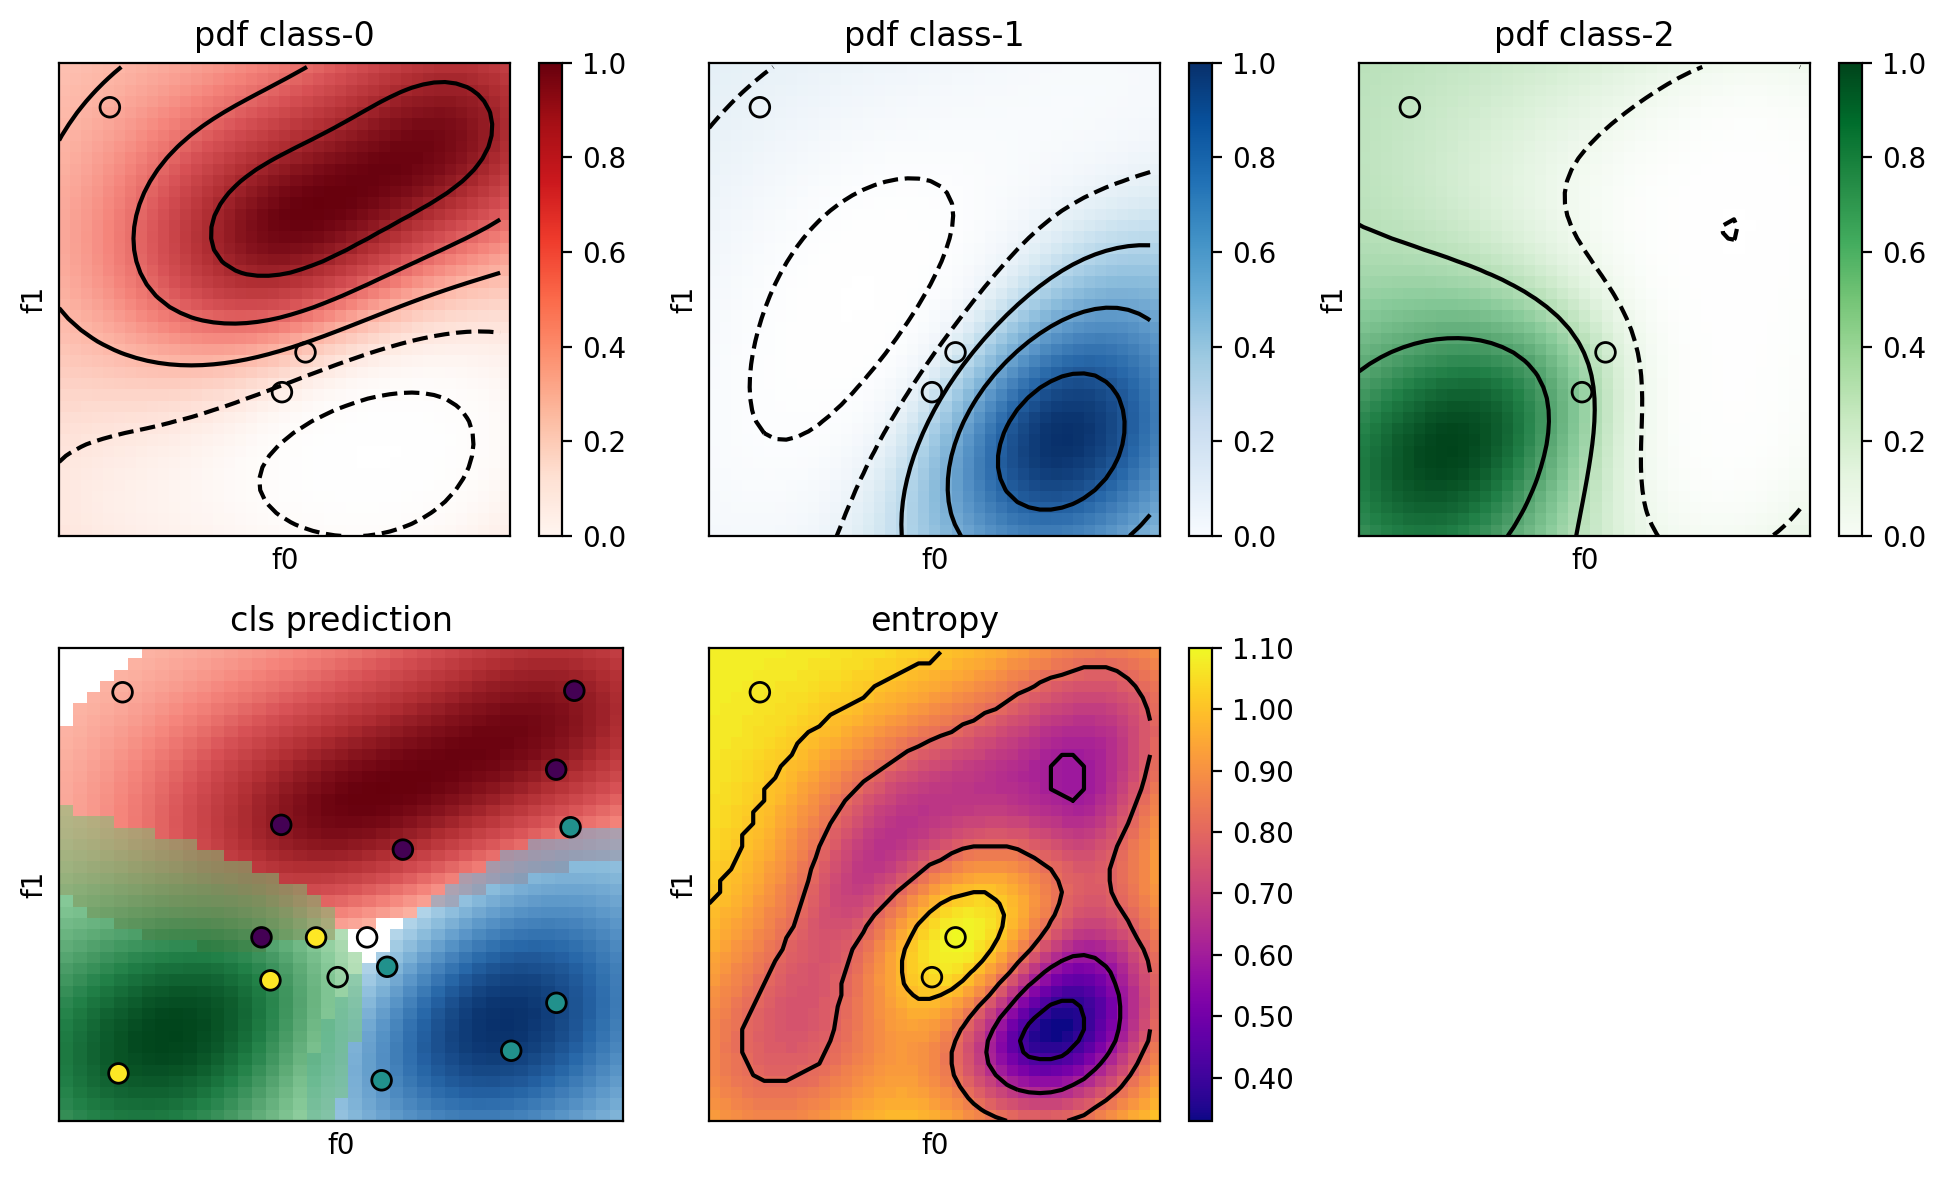

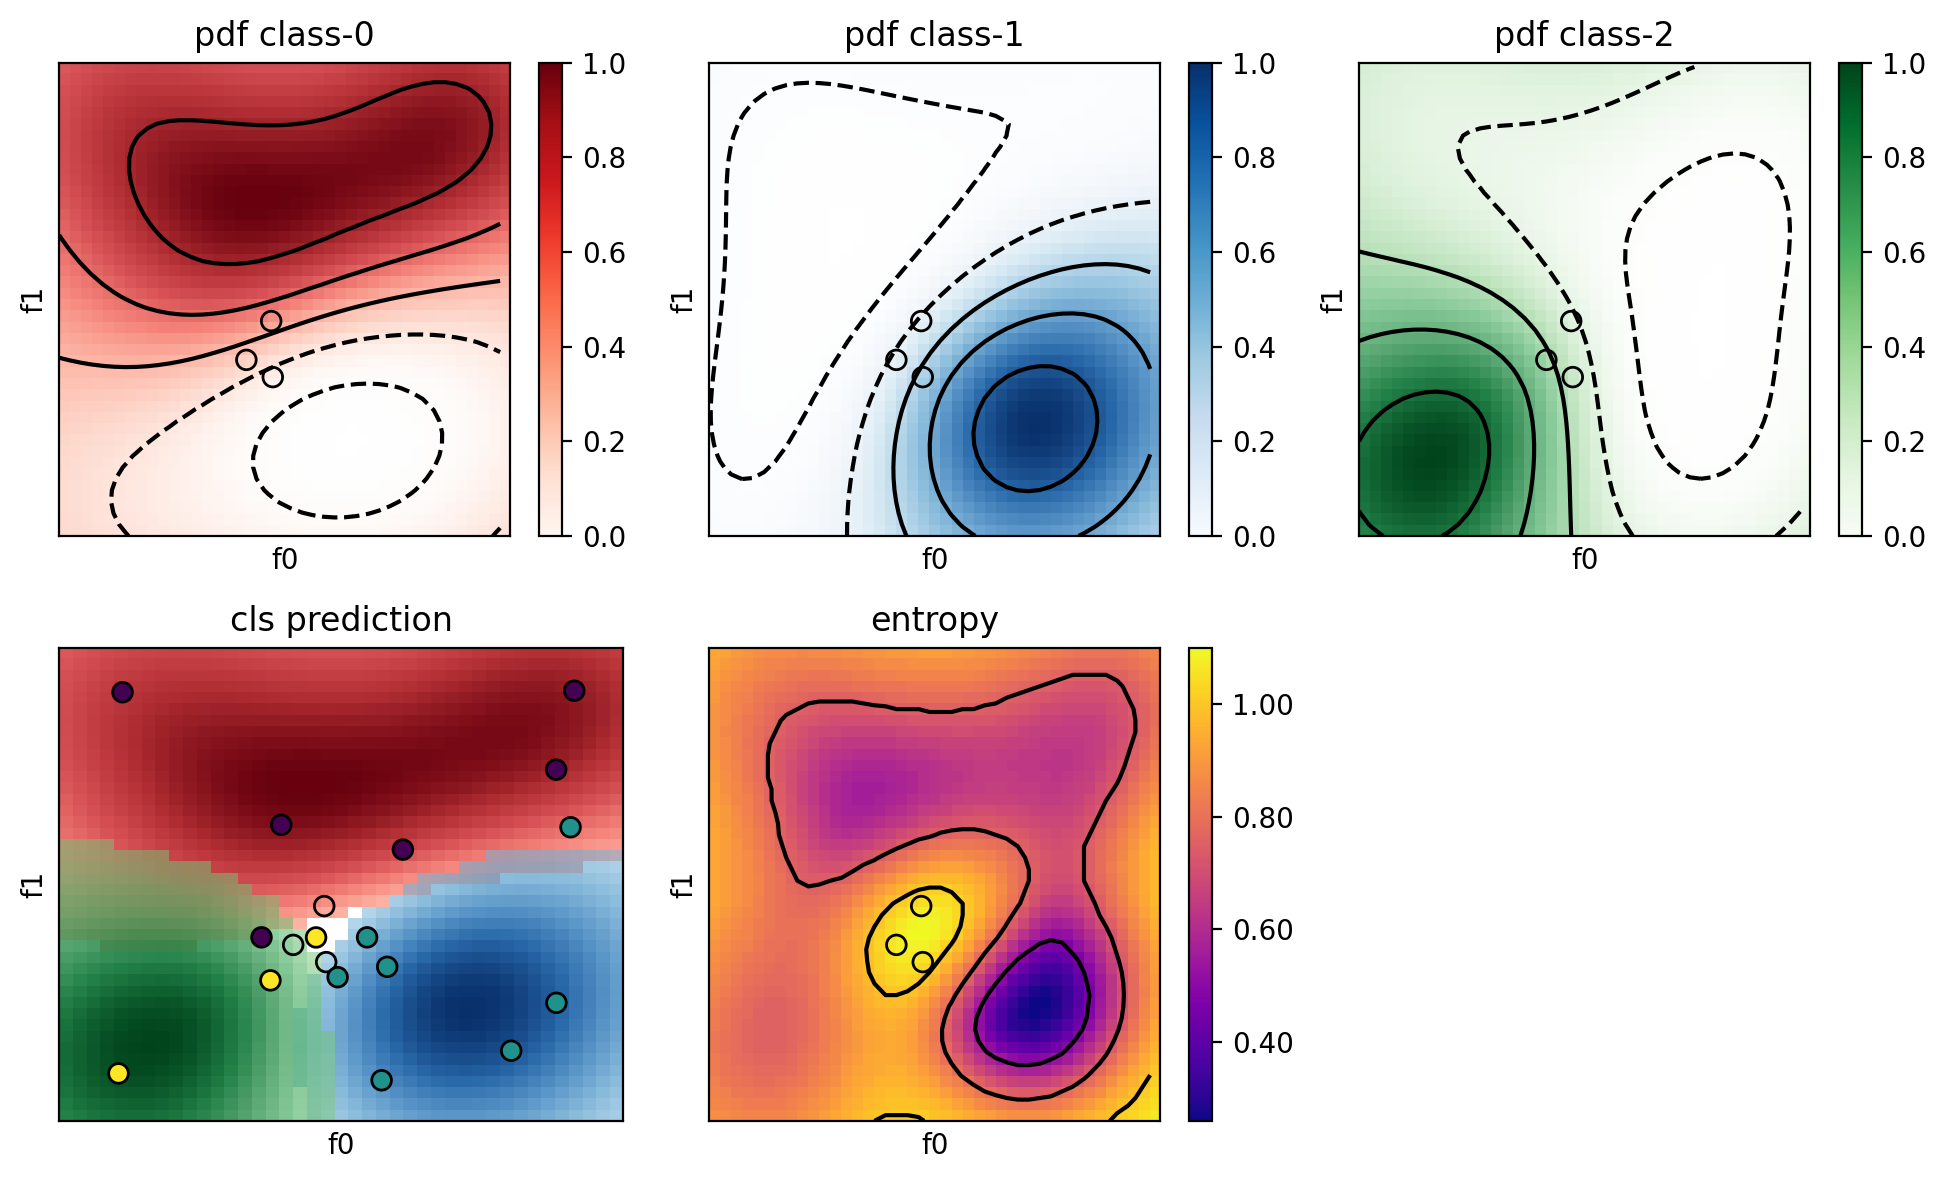

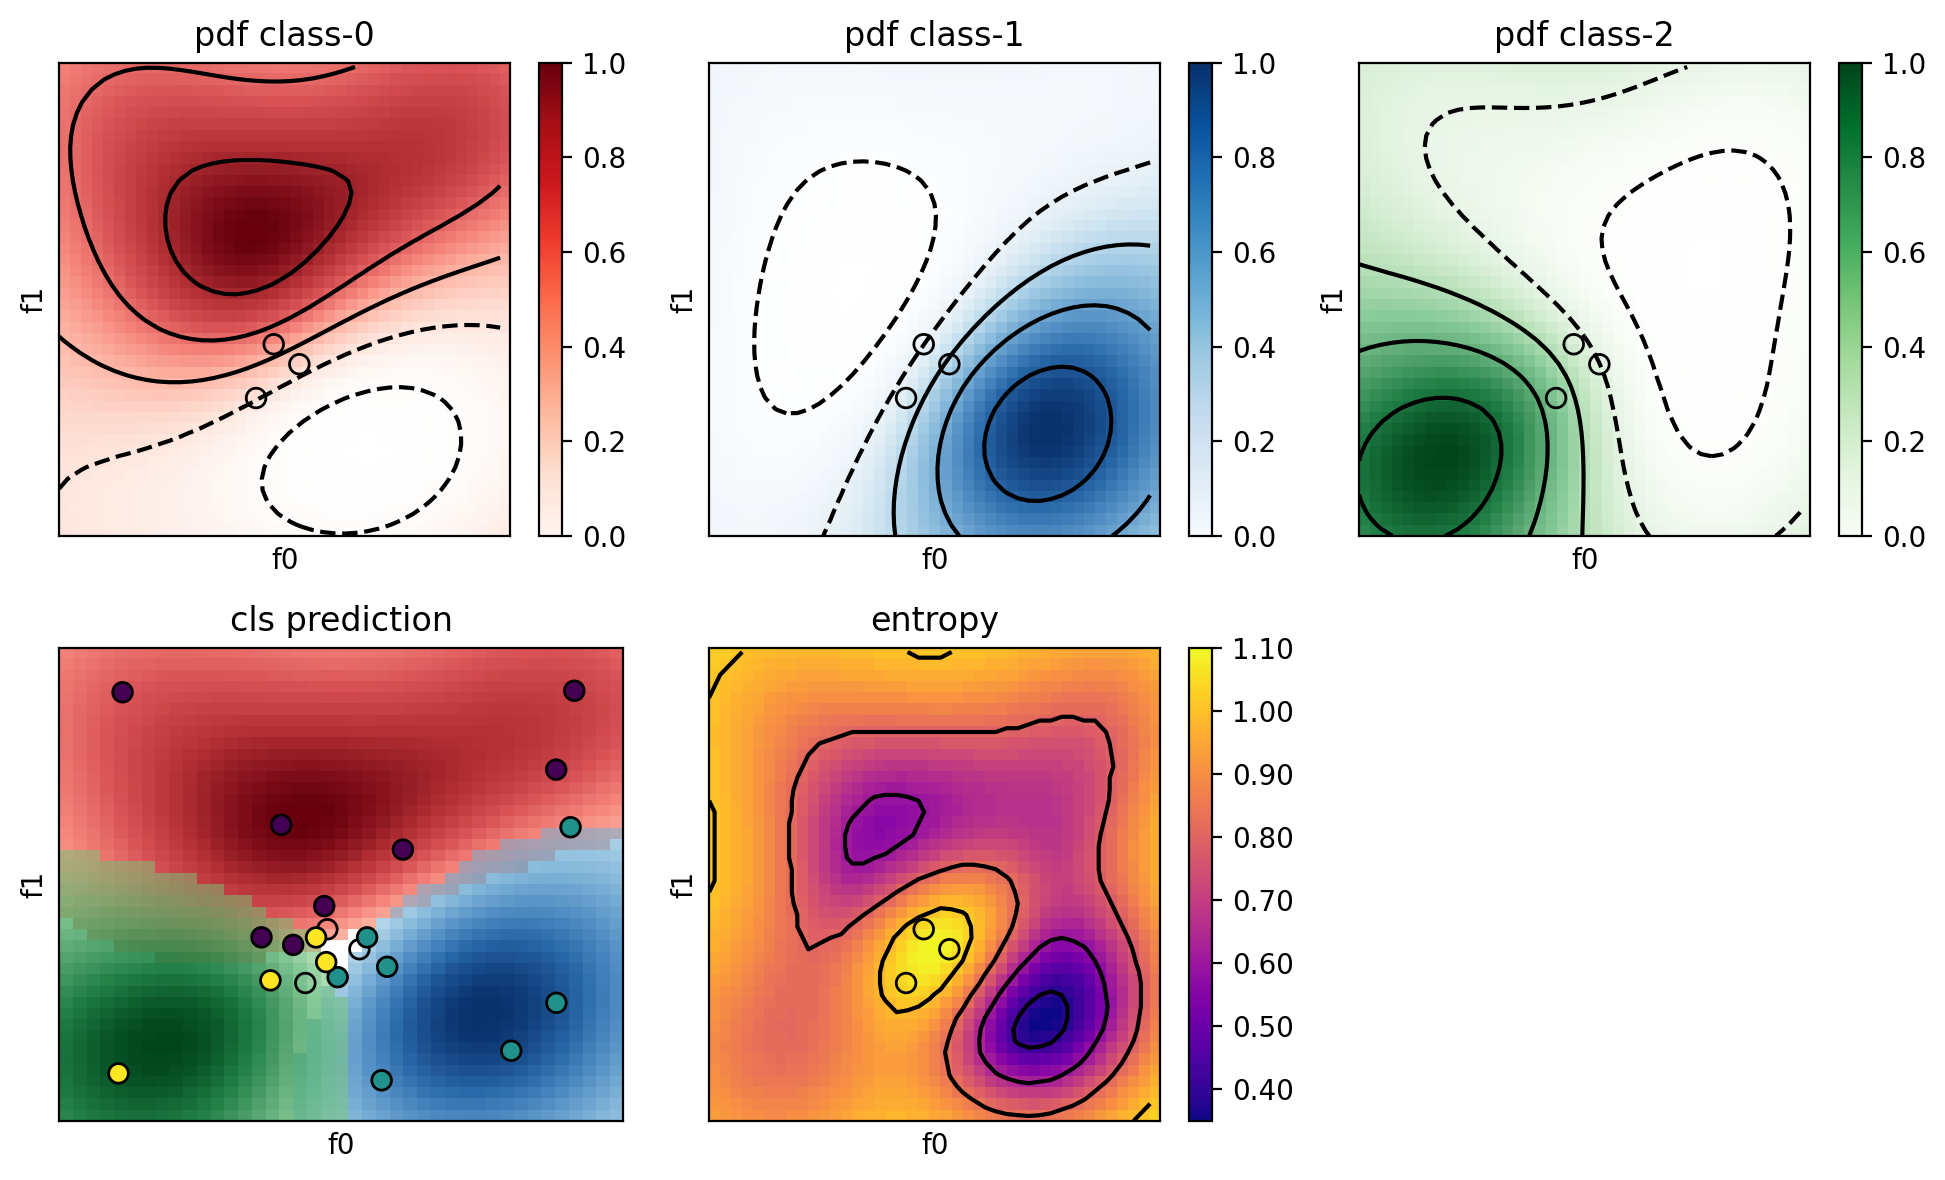

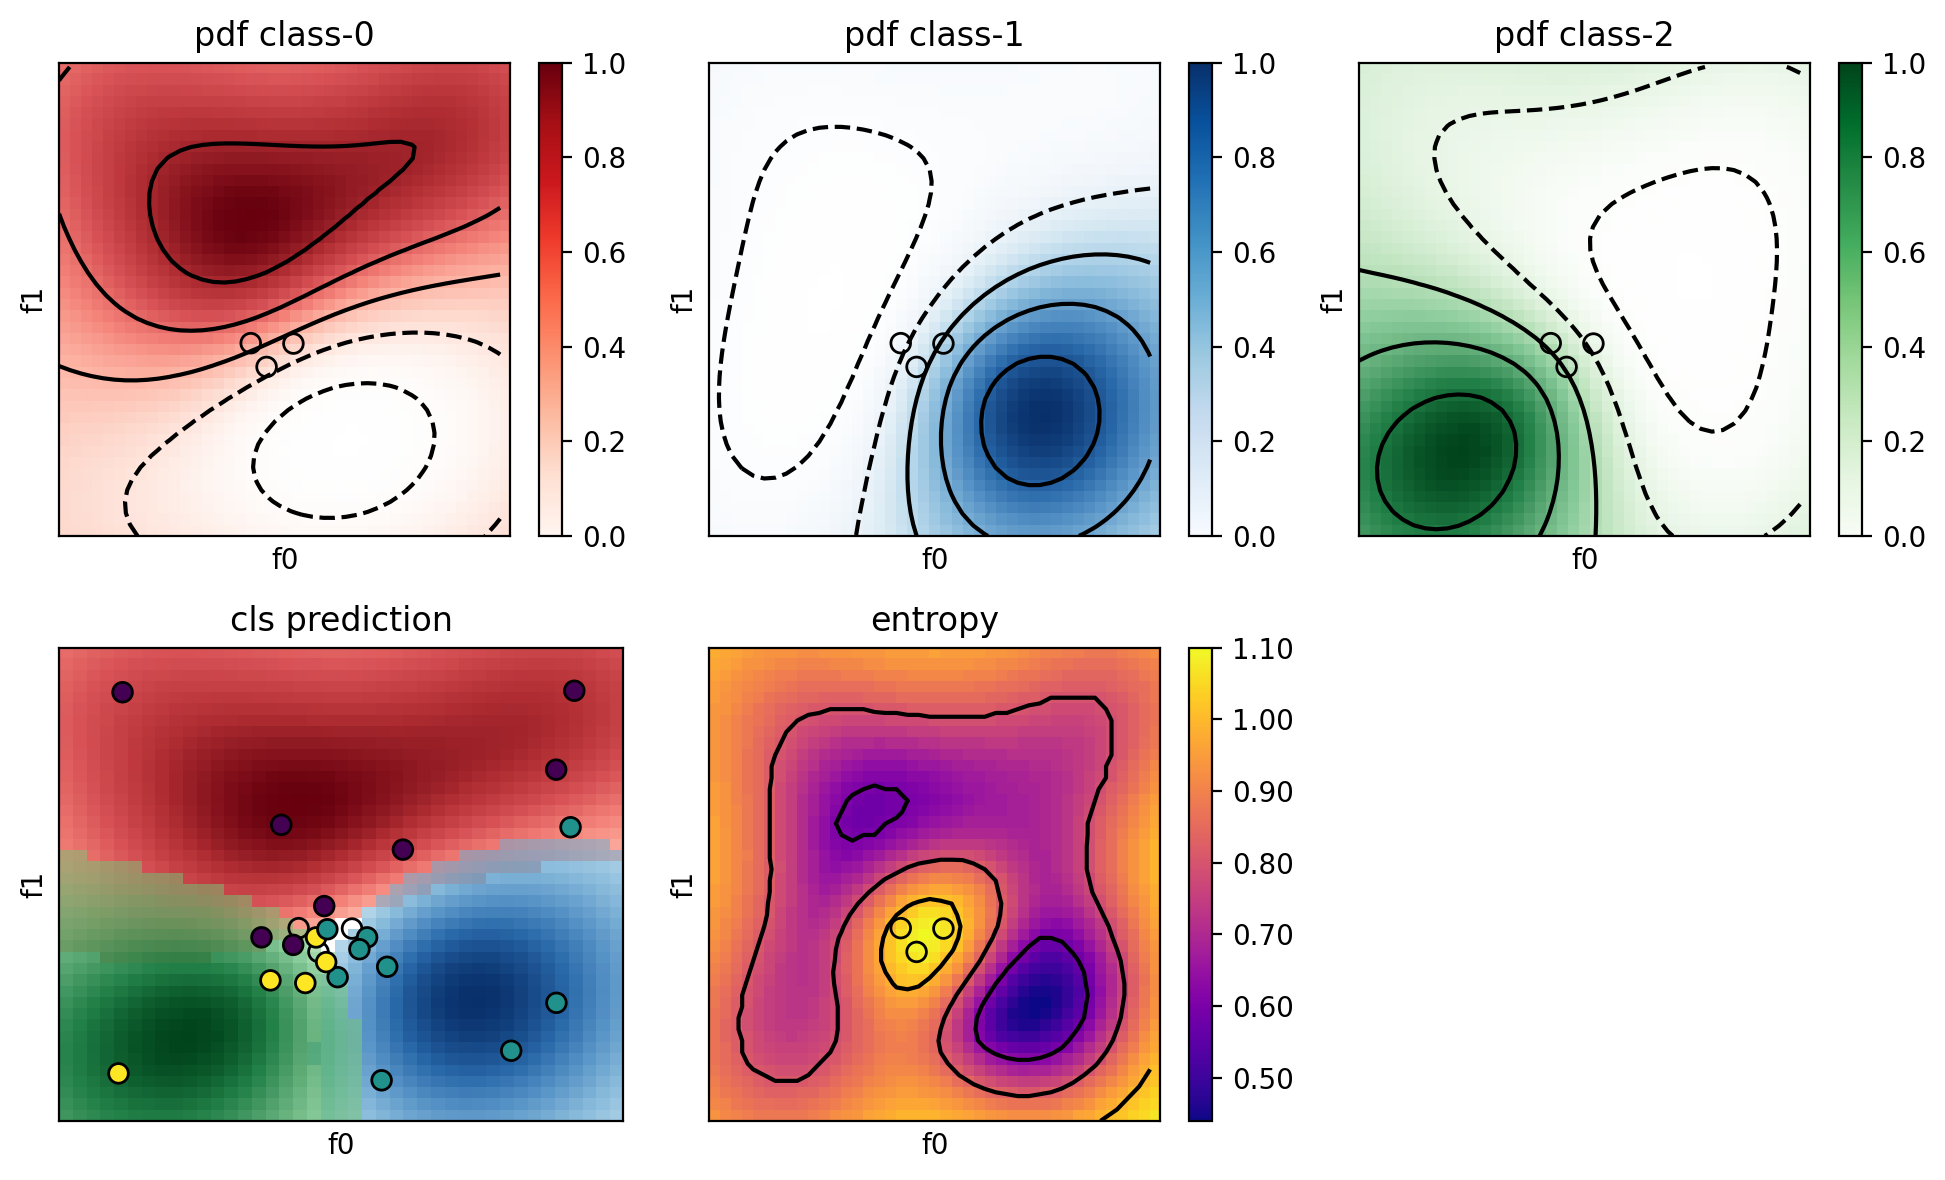

In [42]:
idxs = start_idxs
new_idxs = []

for cycle in range(n_cycles):

    idxs = idxs + new_idxs

    print(f'Cycle-{cycle}')
    print(f'ALpoints: {len(idxs)} / {len(data.X)}')

    new_idxs = active_learning_cycle(
        feature_space=(data.X, data.y),
        idxs=idxs,
        new_batch=n_batch,
        clfModel=al_clf,
        acquisitionFunc=ac_func,
        screeningSelection=sampl_mode,
    )

    alclf.beauty.plot_active_learning_cycle(
        feature_space=(X0,X1,data.y),
        clfModel=al_clf,
        idxs=idxs,
        new_idxs=new_idxs,
    )